In [ ]:
!unzip "bottle_images.zip"
!unzip "chips_images.zip"
!unzip "straws_images.zip"

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import os

In [3]:
def imshow(img):
    print(img.shape)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def myimshow(img):
    plt.imshow(img, cmap="gray")
    plt.show()

def standardize(A):
  return (A - np.mean(A)) / (np.max(A) - np.mean(A))

In [4]:
def read_files(filename, class_index):
  X_list = []
  Y_list = []
  for file in os.listdir(filename):
    try:
      numpy_file = plt.imread(filename + "/" + file)
    except:
      continue
    X_list.append(numpy_file)
    Y_list.append(class_index)
  return X_list, Y_list

In [5]:
filename_list = ["bottle_images", "chips_images", "straws_images"]
X_list = []
Y_list = []
for i, filename in enumerate(filename_list):
  X, Y = read_files(filename, i)
  X_list += X
  Y_list += Y
classes = {i:filename_list[i] for i in range(len(filename_list))}
print(classes)

{0: 'bottle_images', 1: 'chips_images', 2: 'straws_images'}


In [6]:
data_set = []
for i in range(len(X_list)):
  img = Image.fromarray(X_list[i], "RGB")
  reshaped_img = img.resize((200, 200))
  data_set.append((torch.from_numpy(standardize(np.array(reshaped_img).transpose(2,0,1))), Y_list[i]))
print(len(data_set))

2110


In [7]:
np.random.shuffle(data_set)
split_point_val = int(len(X_list) * 0.6)
split_point_test = int(len(X_list) * 0.8)
train_set = data_set[:split_point_val]
val_set = data_set[split_point_val:split_point_test]
test_set = data_set[split_point_test:]
print("train_set: ", str(len(train_set)))
print("val_set: ", str(len(val_set)))
print("test_set: ", str(len(test_set)))
print("total:" , str(len(train_set) + len(val_set) + len(test_set)))

train_set:  1266
val_set:  422
test_set:  422
total: 2110


In [8]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 204, 810])


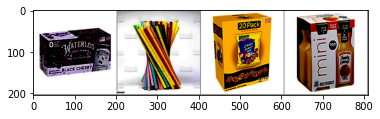

['bottle_images', 'straws_images', 'chips_images', 'bottle_images']


In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# fig, axs = plt.subplots(ncols = 4, figsize = (15,15))
# for i in range(4):
#   axs[i].imshow(images[i])
plt.show()
print([classes[int(labels[i])] for i in range(4)])

In [ ]:
#load the model
#trained model was failed to be downloaded from googlecolab as it is really big (~300M)
simpleModel = SimpleModel()
simpleModel.load_state_dict(torch.load("model.txt"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
simpleModel.to(device)
simpleModel.eval()

In [26]:
 import torch.optim as optim

dropout = 0.5

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, kernel_size = 3)
        self.bn1 = nn.BatchNorm2d(30)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(30, 60, kernel_size = 3)
        self.bn2 = nn.BatchNorm2d(60)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(60 * 48 * 48, 1200)
        self.fc2 = nn.Linear(1200, 840)
        self.fc3 = nn.Linear(840, 14)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = x.view(-1, 60 * 48 * 48)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

simpleModel = SimpleModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
simpleModel.to(device)

cuda:0


SimpleModel(
  (conv1): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=138240, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=840, bias=True)
  (fc3): Linear(in_features=840, out_features=14, bias=True)
)

In [27]:
lr = 0.01
weight_decay = 0.13
step_size = 15
gamma = 0.6
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simpleModel.parameters(), lr = lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


In [28]:
tr_accuacy2 = []
tr_loss2 = []
va_accuacy2 = []
va_loss2 = []

batch_size_i = 20
val_batch_size = 1
for epoch in range(100):  # loop over the dataset multiple times
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_i, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=False, num_workers=2)
    train_total = 0
    train_correct = 0
    va_total = 0
    va_correct = 0
    training_loss = 0.0
    vaild_loss = 0.0
    training_data_size = 0
    va_data_size = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), \
          labels.to(device)
        optimizer.zero_grad()
        outputs = simpleModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        optimizer.step()
        training_loss += loss.item()
        training_data_size = i
    tr_accuacy2.append(train_correct / train_total)
    tr_loss2.append(training_loss / (training_data_size + 1))

    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), \
          labels.to(device)
        # optimizer.zero_grad()
        outputs = simpleModel(inputs)
        loss = criterion(outputs, labels)
        # loss.backward()
        _, predicted = torch.max(outputs.data, 1)
        va_total += labels.size(0)
        va_correct += (predicted == labels).sum().item()
        vaild_loss += loss.item()
        va_data_size = i
    va_accuacy2.append(va_correct / va_total)
    va_loss2.append(vaild_loss / (va_data_size + 1))
    if scheduler.get_lr()[0] > 0.0003:
        scheduler.step()
    if epoch % 2 == 0:

        print('epoch %d learning rate:%.5f| training loss:%.3f, training accuracy:%.2f%%, validation loss:%.3f, validation accuracy:%.2f%%' 
              %(epoch + 1, scheduler.get_last_lr()[0], training_loss / (training_data_size + 1), \
                100 * train_correct / train_total, \
                vaild_loss / (va_data_size + 1), 100 * va_correct / va_total))

epoch 1 learning rate:0.01000| training loss:0.710, training accuracy:78.20%, validation loss:0.682, validation accuracy:77.73%


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


epoch 3 learning rate:0.01000| training loss:0.221, training accuracy:93.52%, validation loss:0.723, validation accuracy:77.49%
epoch 5 learning rate:0.01000| training loss:0.139, training accuracy:96.13%, validation loss:0.597, validation accuracy:84.60%
epoch 7 learning rate:0.01000| training loss:0.112, training accuracy:97.16%, validation loss:0.642, validation accuracy:81.28%
epoch 9 learning rate:0.01000| training loss:0.096, training accuracy:98.26%, validation loss:0.619, validation accuracy:82.23%
epoch 11 learning rate:0.01000| training loss:0.089, training accuracy:98.82%, validation loss:0.618, validation accuracy:81.99%
epoch 13 learning rate:0.01000| training loss:0.091, training accuracy:98.89%, validation loss:0.592, validation accuracy:84.12%
epoch 15 learning rate:0.00600| training loss:0.092, training accuracy:98.42%, validation loss:0.586, validation accuracy:83.41%
epoch 17 learning rate:0.00600| training loss:0.081, training accuracy:99.29%, validation loss:0.553,

In [30]:
test_total = 0
test_correct = 0
test_loss = 0.0
test_data_size = 0
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device, dtype=torch.float), \
      labels.to(device)
    # optimizer.zero_grad()
    outputs = simpleModel(inputs)
    loss = criterion(outputs, labels)
    # loss.backward()
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()
    test_loss += loss.item()
    test_data_size = i
print("test loss:%.3f, test accuracy:%.2f%%" %(\
      test_loss / (test_data_size + 1), 100 * test_correct / test_total))

test loss:0.223, test accuracy:94.31%


In [ ]:
torch.save(simpleModel.state_dict(), "model.txt")